# Trial-to-Paid Conversion Prediction - ML Zoomcamp Capstone 1 Project

## Problem Description

This project predicts whether a trial user will convert to a paid subscription in the PushMetrics platform.

**Business Context**: PushMetrics helps teams build and schedule analytics reports that:
- Query databases (BigQuery, Snowflake, MySQL, ClickHouse, etc.)
- Generate visualizations (Plotly, tables, KPI cards)
- Deliver results via email/Slack/cloud storage

**Why predict trial conversion?**
- Prioritize sales and onboarding outreach
- Focus support on high-risk trials
- Improve activation and retention

**ML Problem**: Binary classification
- Target: `converted_to_paid` (0 = churned, 1 = converted)
- Features: Trial activation, usage, automation, team signals, integrations
- Dataset: 237 trial users
- Metric: ROC AUC (handles class imbalance)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

import xgboost as xgb
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
print('Libraries loaded successfully!')


Libraries loaded successfully!


In [2]:

# Load dataset
DATA_FILE = 'data.csv'
df = pd.read_csv(DATA_FILE)

print(f"Dataset shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {list(df.columns)}")


Dataset shape: (237, 64)
Columns (64): ['customer_id', 'organization_id', 'converted_to_paid', 'outcome', 'trial_start', 'trial_end', 'trial_duration_days', 'trial_subscription_id', 'hours_to_first_report', 'hours_to_first_execution', 'hours_to_first_sql_connection', 'hours_to_first_schedule', 'activated_day1', 'activated_day2', 'activated_week1', 'reports_created', 'reports_week1', 'reports_week2', 'blocks_created', 'unique_block_types', 'executions_total', 'executions_week1', 'executions_week2', 'executions_success', 'executions_failed', 'execution_growth_rate', 'execution_success_rate', 'avg_execution_duration', 'has_sql_block', 'has_plotly_block', 'has_kpi_block', 'has_table_block', 'has_slack_block', 'has_email_block', 'has_tableau_block', 'has_api_block', 'has_storage_block', 'has_parameters', 'has_control_flow', 'sql_blocks_count', 'viz_blocks_count', 'sql_connections_count', 'unique_db_types_count', 'has_bigquery', 'has_snowflake', 'has_redshift', 'has_postgres', 'has_clickhous

In [3]:
# EDA: Conversion rates for key segments
import pandas as pd

if 'df' in globals():
    df_eda = df.copy()
else:
    df_eda = pd.read_csv('data.csv')

median_first_exec = df_eda['hours_to_first_execution'].median()
within_24 = df_eda['hours_to_first_execution'] <= 24
never_exec = df_eda['hours_to_first_execution'] >= 999
rate_within_24 = df_eda.loc[within_24, 'converted_to_paid'].mean()
rate_never = df_eda.loc[never_exec, 'converted_to_paid'].mean()

rate_generic = df_eda.loc[df_eda['is_generic_email'] == 1, 'converted_to_paid'].mean()
rate_business = df_eda.loc[df_eda['is_generic_email'] == 0, 'converted_to_paid'].mean()

bins = [-1, 0, 1, 3, 5, 10, df_eda['users_invited'].max()]
labels = ['0', '1', '2-3', '4-5', '6-10', '11+']
df_eda['users_invited_bucket'] = pd.cut(df_eda['users_invited'], bins=bins, labels=labels)
rate_invites = df_eda.groupby('users_invited_bucket', observed=True)['converted_to_paid'].mean()
counts_invites = df_eda.groupby('users_invited_bucket', observed=True)['converted_to_paid'].size()

rate_bq = df_eda.loc[df_eda['has_bigquery'] == 1, 'converted_to_paid'].mean() if 'has_bigquery' in df_eda.columns else None
if 'has_snowflake' in df_eda.columns:
    snowflake_mask = df_eda['has_snowflake'] == 1
    if snowflake_mask.any():
        rate_snowflake = df_eda.loc[snowflake_mask, 'converted_to_paid'].mean()
    else:
        rate_snowflake = 0.0
else:
    rate_snowflake = None

rate_sched = df_eda.loc[df_eda['schedules_created'] > 0, 'converted_to_paid'].mean()
rate_no_sched = df_eda.loc[df_eda['schedules_created'] == 0, 'converted_to_paid'].mean()

print(f"Median time to first execution: {median_first_exec:.0f} hours")
print(f"Conversion if execute within 24h: {rate_within_24:.1%}")
print(f"Conversion if never execute: {rate_never:.1%}")
print(f"Generic email conversion: {rate_generic:.1%}")
print(f"Business email conversion: {rate_business:.1%}")
print(f"BigQuery conversion: {rate_bq:.1%}" if rate_bq == rate_bq else "BigQuery conversion: n/a")
if rate_snowflake is None:
    print('Snowflake conversion: n/a')
elif rate_snowflake == 0.0:
    print('Snowflake conversion: 0.0% (no Snowflake users)')
else:
    print(f"Snowflake conversion: {rate_snowflake:.1%}")
print(f"Schedules created conversion: {rate_sched:.1%}")
print(f"No schedules conversion: {rate_no_sched:.1%}")
print("Conversion by users_invited bucket:")
print((rate_invites * 100).round(1).astype(str) + '%')
print("Counts by users_invited bucket:")
print(counts_invites)


Median time to first execution: 999 hours
Conversion if execute within 24h: 20.5%
Conversion if never execute: 48.6%
Generic email conversion: 4.8%
Business email conversion: 51.3%
BigQuery conversion: 100.0%
Snowflake conversion: 0.0% (no Snowflake users)
Schedules created conversion: 35.7%
No schedules conversion: 44.0%
Conversion by users_invited bucket:
users_invited_bucket
0        4.9%
1       37.5%
2-3     53.8%
4-5     68.2%
6-10    64.3%
11+     67.6%
Name: converted_to_paid, dtype: object
Counts by users_invited bucket:
users_invited_bucket
0       82
1        8
2-3     26
4-5     22
6-10    28
11+     71
Name: converted_to_paid, dtype: int64


In [4]:
# First few rows
df.head()

,customer_id,organization_id,converted_to_paid,outcome,trial_start,trial_end,trial_duration_days,trial_subscription_id,hours_to_first_report,hours_to_first_execution,...,users_invited,workspaces_created,active_users_count,team_engagement_rate,is_generic_email,accepted_terms,trial_start_hour,trial_start_day_of_week,trial_start_is_weekend,trial_start_is_business_hours
0,75aa504256b37dec,9034a44fc85ff564,1,CONVERTED,2025-12-29 17:23:40,2025-12-29 19:15:54,0.0,542e7cd00e05fc0a,999.000000,999.000000,...,3,0,0,0.0,1,1,17.0,1.0,0,1
1,e422cd10452279a8,506d1f604822aa95,0,CHURNED,2025-12-02 21:02:33,2025-12-16 21:02:33,14.0,7302c7eea43ee602,47.881091,0.000976,...,0,0,0,0.0,1,1,21.0,2.0,0,0
2,ee67dd1f319a0820,896834060dcbc29a,0,CHURNED,2025-11-18 04:15:02,2025-12-02 04:15:02,14.0,c4531ee9671e27c6,16.287688,0.806558,...,1,0,0,0.0,0,1,4.0,2.0,0,0
3,c94001bf4f173db9,2e455d37ec3ef75d,0,CHURNED,2025-10-31 06:56:30,2025-11-14 06:56:30,14.0,377a3d6adaca5e8b,999.000000,999.000000,...,0,0,0,0.0,1,0,6.0,5.0,0,0
4,ae4c377c05f328a0,24b80d1053224fd8,0,CHURNED,2025-10-21 19:35:21,2025-11-04 18:35:21,13.0,d972c41e08c7a510,999.000000,999.000000,...,0,0,0,0.0,0,0,19.0,2.0,0,0


In [5]:
# Data types
df.dtypes

customer_id                       object
organization_id                   object
converted_to_paid                  int64
outcome                           object
trial_start                       object
                                  ...   
accepted_terms                     int64
trial_start_hour                 float64
trial_start_day_of_week          float64
trial_start_is_weekend             int64
trial_start_is_business_hours      int64
Length: 64, dtype: object

In [6]:
# Basic statistics
df.describe(include="all")

,customer_id,organization_id,converted_to_paid,outcome,trial_start,trial_end,trial_duration_days,trial_subscription_id,hours_to_first_report,hours_to_first_execution,...,users_invited,workspaces_created,active_users_count,team_engagement_rate,is_generic_email,accepted_terms,trial_start_hour,trial_start_day_of_week,trial_start_is_weekend,trial_start_is_business_hours
count,237,110,237.000000,237,237,237,237.000000,237,237.000000,237.000000,...,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
unique,237,110,NaN,2,236,236,NaN,237,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,75aa504256b37dec,9034a44fc85ff564,NaN,CHURNED,2023-11-02 23:20:20,2023-11-16 23:20:20,NaN,542e7cd00e05fc0a,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,135,2,2,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.430380,NaN,NaN,NaN,14.202532,NaN,916.659814,772.780660,...,15.725738,0.008439,0.071730,0.012494,0.177215,0.375527,14.848101,3.000000,0.054852,0.459916
std,NaN,NaN,0.496177,NaN,NaN,NaN,3.414996,NaN,260.518064,409.085396,...,39.975584,0.091668,0.440438,0.073030,0.382659,0.485284,5.960510,1.467155,0.228174,0.499445
min,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,0.211048,0.000976,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,NaN,NaN,NaN,14.000000,NaN,999.000000,999.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,2.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,NaN,NaN,NaN,14.000000,NaN,999.000000,999.000000,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,3.000000,0.000000,0.000000
75%,NaN,NaN,1.000000,NaN,NaN,NaN,14.000000,NaN,999.000000,999.000000,...,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,4.000000,0.000000,1.000000


In [7]:

# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
})

print("Missing values:")
print(missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False))


Missing values:
                       Missing  Percentage
execution_growth_rate      184       77.64
organization_id            127       53.59


## 2. Target Variable Analysis

In [8]:

# Class distribution
print("Target variable distribution:")
print(df['converted_to_paid'].value_counts())
print("Percentage:")
print(df['converted_to_paid'].value_counts(normalize=True) * 100)

conversion_rate = df['converted_to_paid'].mean() * 100
print(f"Overall conversion rate: {conversion_rate:.2f}%")


Target variable distribution:
converted_to_paid
0    135
1    102
Name: count, dtype: int64
Percentage:
converted_to_paid
0    56.962025
1    43.037975
Name: proportion, dtype: float64
Overall conversion rate: 43.04%


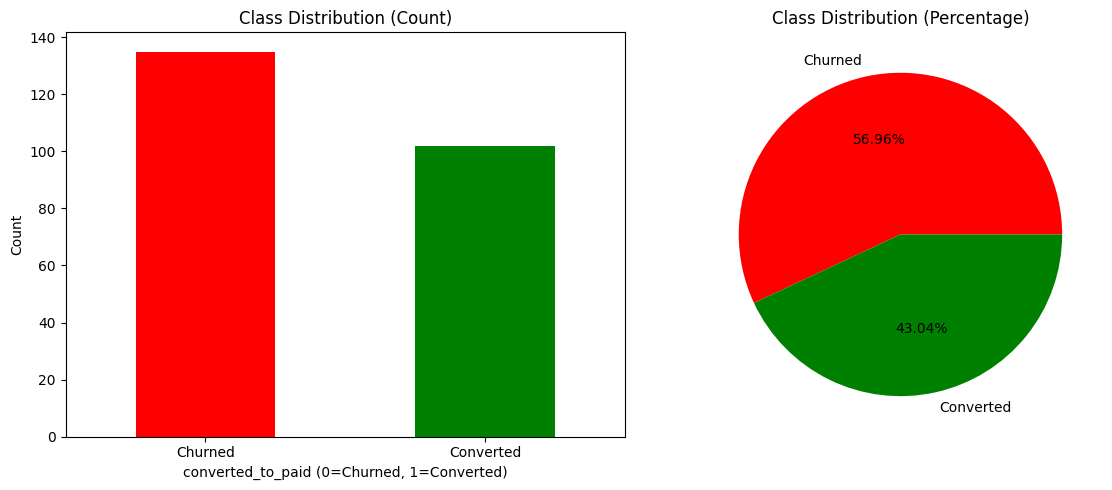

In [9]:

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
df['converted_to_paid'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Class Distribution (Count)')
axes[0].set_xlabel('converted_to_paid (0=Churned, 1=Converted)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Churned', 'Converted'], rotation=0)

# Pie chart
df['converted_to_paid'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%',
                                  labels=['Churned', 'Converted'], colors=['red', 'green'])
axes[1].set_title('Class Distribution (Percentage)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


## 3. Feature Analysis

In [10]:

# Identify feature columns (exclude identifiers, dates, target, outcome)
exclude_cols = [
    'customer_id', 'organization_id', 'trial_subscription_id',
    'trial_start', 'trial_end', 'outcome', 'converted_to_paid'
]

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total features: {len(feature_cols)}")
print("Feature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")


Total features: 57
Feature list:
 1. trial_duration_days
 2. hours_to_first_report
 3. hours_to_first_execution
 4. hours_to_first_sql_connection
 5. hours_to_first_schedule
 6. activated_day1
 7. activated_day2
 8. activated_week1
 9. reports_created
10. reports_week1
11. reports_week2
12. blocks_created
13. unique_block_types
14. executions_total
15. executions_week1
16. executions_week2
17. executions_success
18. executions_failed
19. execution_growth_rate
20. execution_success_rate
21. avg_execution_duration
22. has_sql_block
23. has_plotly_block
24. has_kpi_block
25. has_table_block
26. has_slack_block
27. has_email_block
28. has_tableau_block
29. has_api_block
30. has_storage_block
31. has_parameters
32. has_control_flow
33. sql_blocks_count
34. viz_blocks_count
35. sql_connections_count
36. unique_db_types_count
37. has_bigquery
38. has_snowflake
39. has_redshift
40. has_postgres
41. has_clickhouse
42. integrations_count
43. has_slack_integration
44. has_tableau_integration
45. 

In [11]:

# Separate numerical and categorical features
numerical_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [col for col in feature_cols if col not in numerical_features]

print(f"Numerical features ({len(numerical_features)}):")
for f in numerical_features:
    print(f"  - {f}")

print(f"Categorical features ({len(categorical_features)}):")
for f in categorical_features:
    print(f"  - {f}")


Numerical features (57):
  - trial_duration_days
  - hours_to_first_report
  - hours_to_first_execution
  - hours_to_first_sql_connection
  - hours_to_first_schedule
  - activated_day1
  - activated_day2
  - activated_week1
  - reports_created
  - reports_week1
  - reports_week2
  - blocks_created
  - unique_block_types
  - executions_total
  - executions_week1
  - executions_week2
  - executions_success
  - executions_failed
  - execution_growth_rate
  - execution_success_rate
  - avg_execution_duration
  - has_sql_block
  - has_plotly_block
  - has_kpi_block
  - has_table_block
  - has_slack_block
  - has_email_block
  - has_tableau_block
  - has_api_block
  - has_storage_block
  - has_parameters
  - has_control_flow
  - sql_blocks_count
  - viz_blocks_count
  - sql_connections_count
  - unique_db_types_count
  - has_bigquery
  - has_snowflake
  - has_redshift
  - has_postgres
  - has_clickhouse
  - integrations_count
  - has_slack_integration
  - has_tableau_integration
  - schedule

## 4. Numerical Feature Distribution

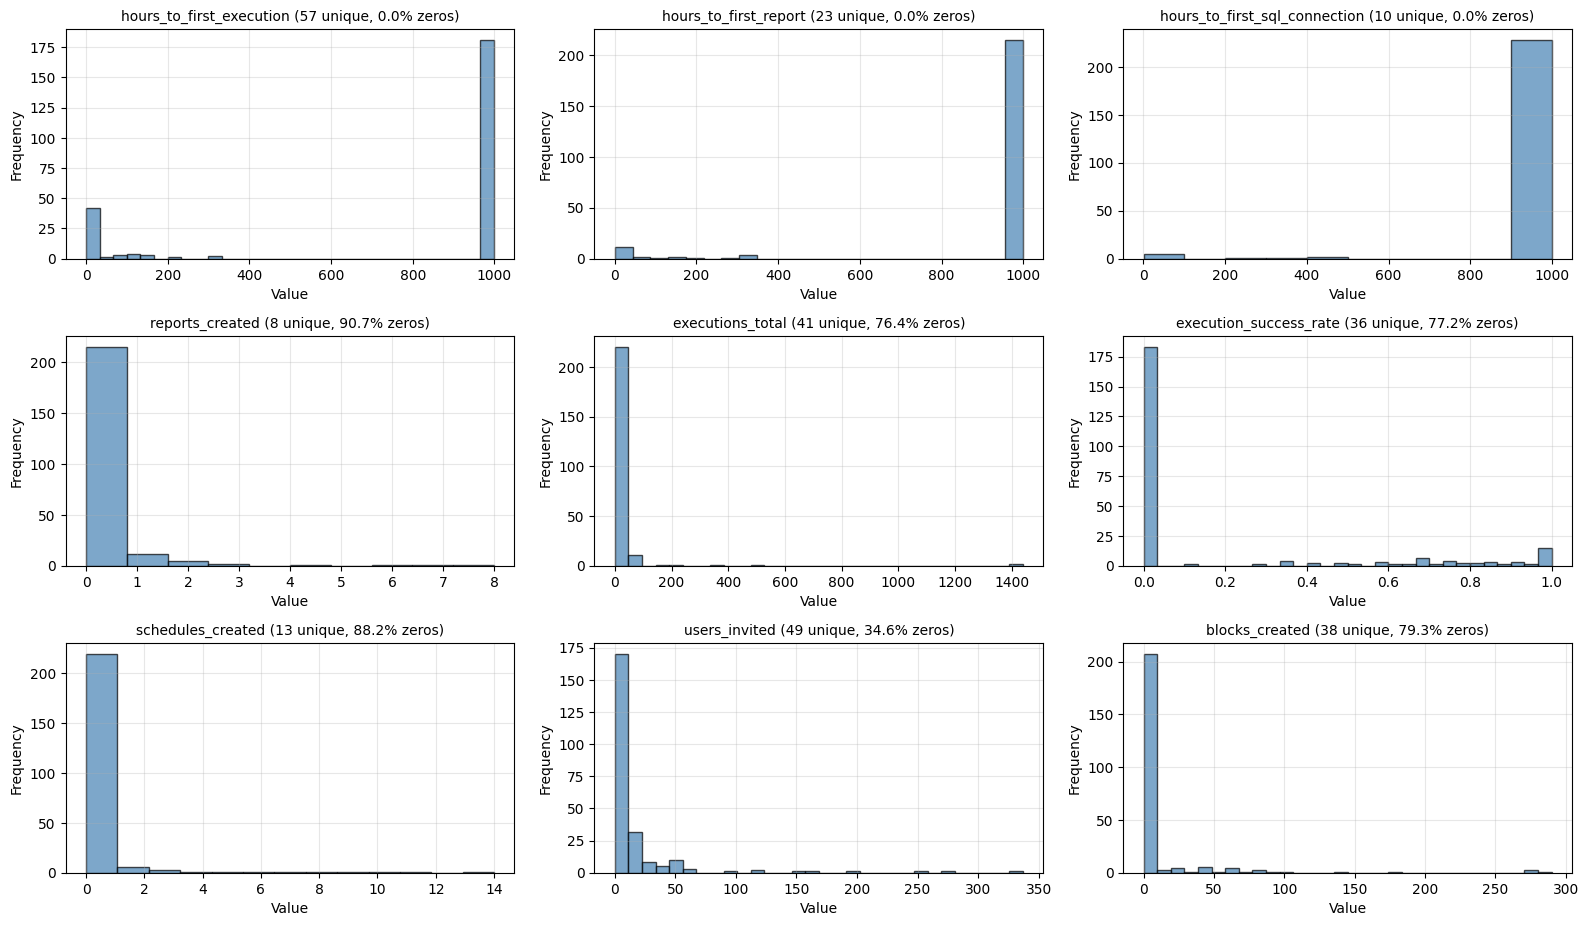

In [12]:

# Focus on key activation/usage metrics
key_numeric = [
    'hours_to_first_execution', 'hours_to_first_report', 'hours_to_first_sql_connection',
    'reports_created', 'executions_total', 'execution_success_rate',
    'schedules_created', 'users_invited', 'blocks_created'
]
key_numeric = [c for c in key_numeric if c in numerical_features]

fig, axes = plt.subplots(len(key_numeric)//3 + 1, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(key_numeric):
    data = df[col].dropna()
    n_unique = data.nunique()
    zero_pct = (data == 0).mean() * 100
    bins = min(max(n_unique, 10), 30)

    axes[idx].hist(data, bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f"{col} ({n_unique} unique, {zero_pct:.1f}% zeros)", fontsize=10)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

for idx in range(len(key_numeric), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


In [13]:

# Summary table for key numeric features
summary = []
for col in key_numeric:
    data = df[col].dropna()
    summary.append({
        'feature': col,
        'unique': data.nunique(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max(),
        '% zeros': (data == 0).mean() * 100
    })

summary_df = pd.DataFrame(summary)
print("Key numeric feature summary:")
print(summary_df)


Key numeric feature summary:
                         feature  unique        mean  median         std  \
0       hours_to_first_execution      57  772.780660   999.0  409.085396   
1          hours_to_first_report      23  916.659814   999.0  260.518064   
2  hours_to_first_sql_connection      10  967.476289   999.0  162.625329   
3                reports_created       8    0.219409     0.0    0.926518   
4               executions_total      41   22.924051     0.0  138.212601   
5         execution_success_rate      36    0.168731     0.0    0.331092   
6              schedules_created      13    0.443038     0.0    1.725287   
7                  users_invited      49   15.725738     4.0   39.975584   
8                 blocks_created      38   11.481013     0.0   41.628765   

        min     max    % zeros  
0  0.000976   999.0   0.000000  
1  0.211048   999.0   0.000000  
2  0.643228   999.0   0.000000  
3  0.000000     8.0  90.717300  
4  0.000000  1439.0  76.371308  
5  0.000000 

## 5. Correlation Analysis

Correlation with target variable (converted_to_paid):
converted_to_paid                1.000000
execution_growth_rate            0.289407
hours_to_first_execution         0.205745
users_invited                    0.152524
schedules_active                 0.122120
has_postgres                     0.106132
workspaces_created               0.106132
has_bigquery                     0.074888
hours_to_first_schedule          0.066758
hours_to_first_report            0.055895
blocks_created                   0.044913
has_kpi_block                    0.032473
trial_duration_days              0.023361
viz_blocks_count                 0.022870
has_parameters                   0.022574
hours_to_first_sql_connection    0.022150
reports_week1                    0.014127
has_control_flow                 0.012972
has_slack_block                  0.012030
trial_start_day_of_week          0.005821
sql_connections_count            0.005644
unique_db_types_count            0.005644
schedules_created     

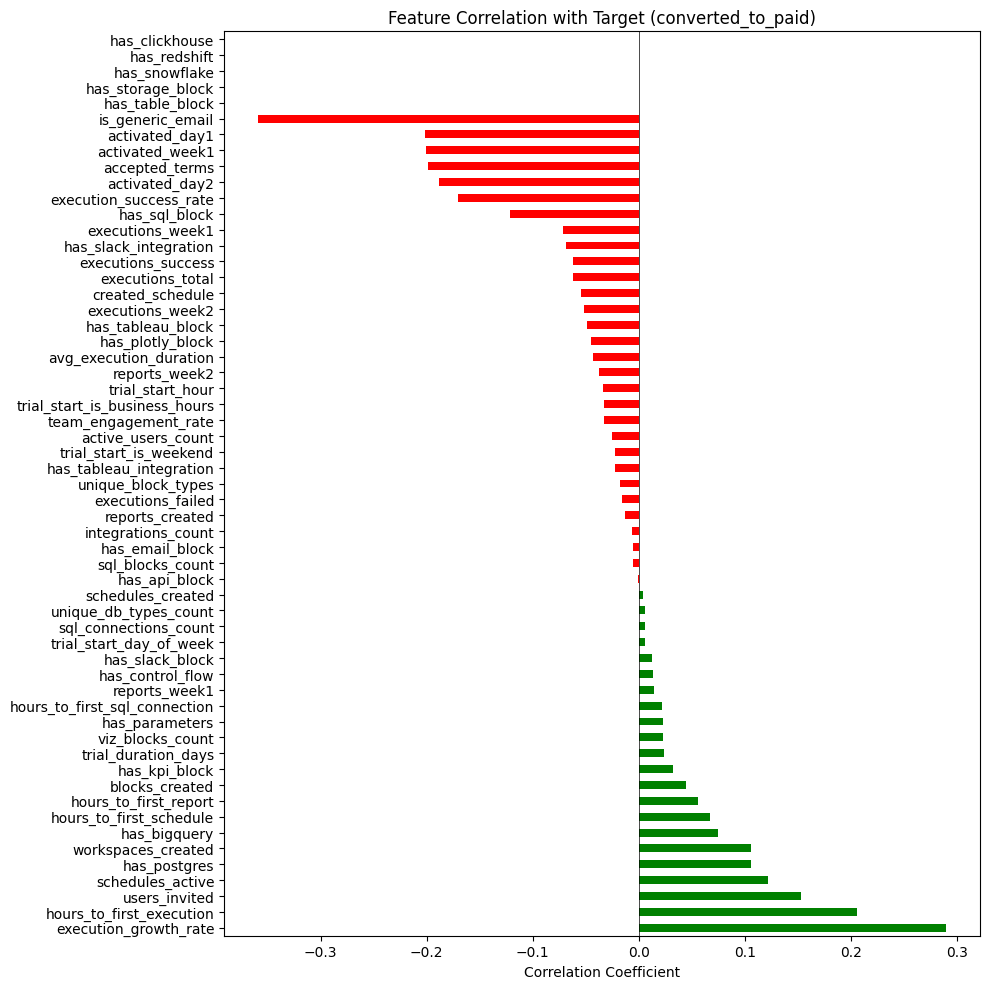

In [14]:

# Correlation with target variable
correlations = df[numerical_features + ['converted_to_paid']].corr()['converted_to_paid'].sort_values(ascending=False)
print("Correlation with target variable (converted_to_paid):")
print(correlations)

plt.figure(figsize=(10, 10))
correlations.drop('converted_to_paid').plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations.drop('converted_to_paid')])
plt.title('Feature Correlation with Target (converted_to_paid)')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


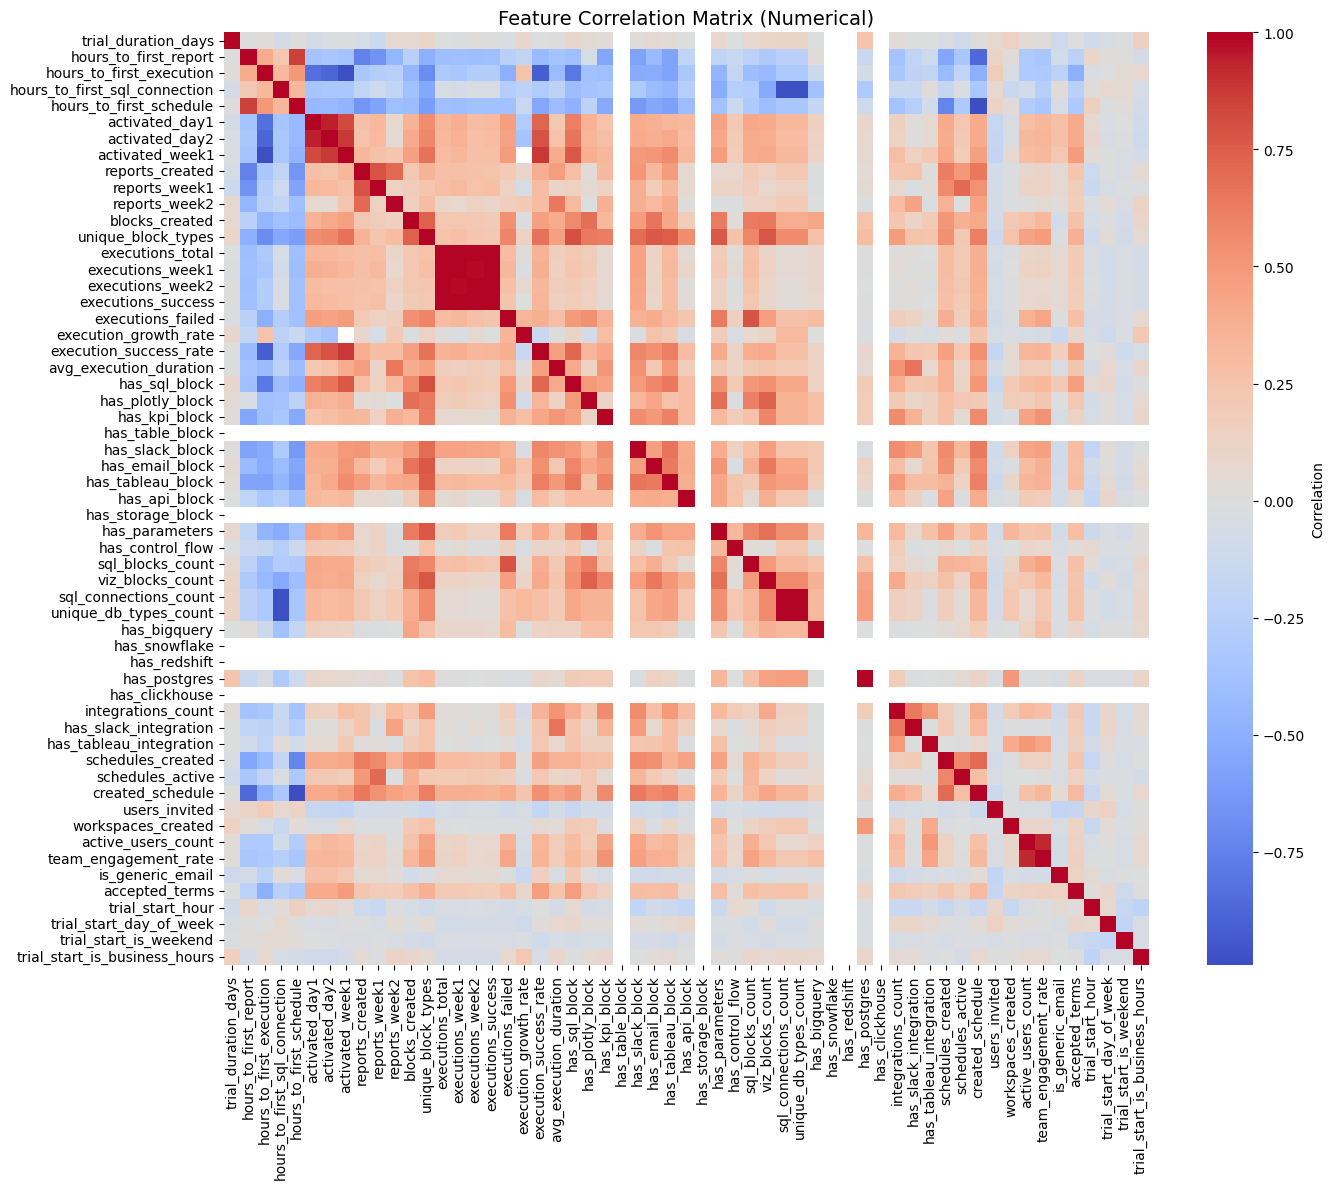

In [15]:

# Feature correlation matrix (numerical only)
plt.figure(figsize=(14, 12))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix (Numerical)', fontsize=14)
plt.tight_layout()
plt.show()


## 6. Categorical Features Analysis

Conversion rate by has_bigquery:
has_bigquery
0     42.79661
1    100.00000
Name: converted_to_paid, dtype: float64


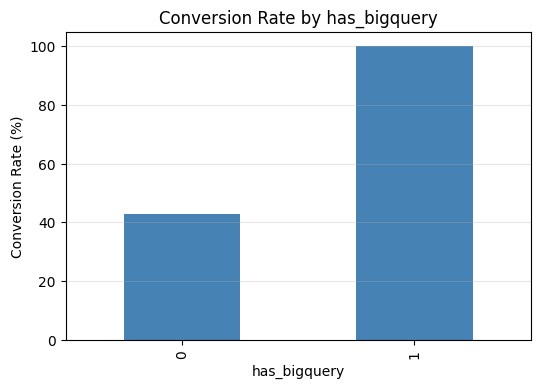

Conversion rate by has_snowflake:
has_snowflake
0    43.037975
Name: converted_to_paid, dtype: float64


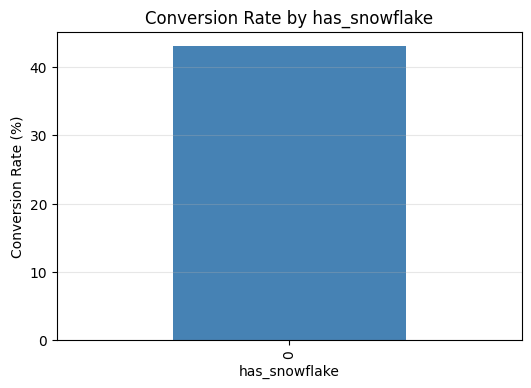

Conversion rate by has_redshift:
has_redshift
0    43.037975
Name: converted_to_paid, dtype: float64


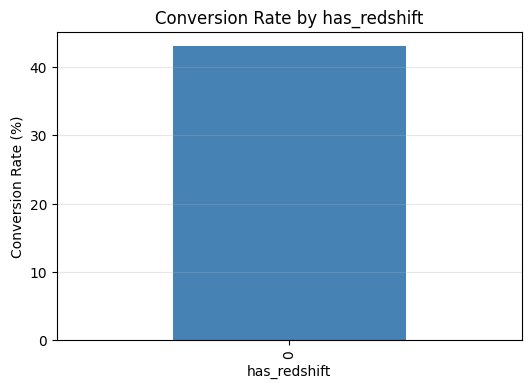

Conversion rate by has_sql_block:
has_sql_block
0    45.876289
1    30.232558
Name: converted_to_paid, dtype: float64


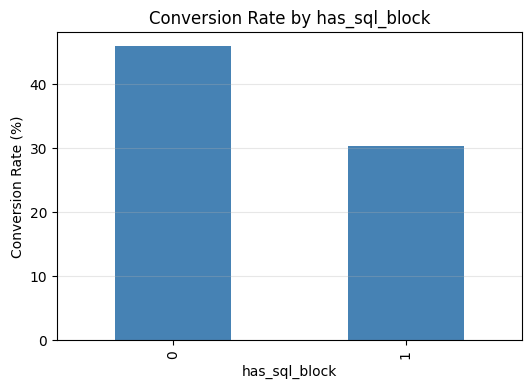

Conversion rate by is_generic_email:
is_generic_email
0    51.282051
1     4.761905
Name: converted_to_paid, dtype: float64


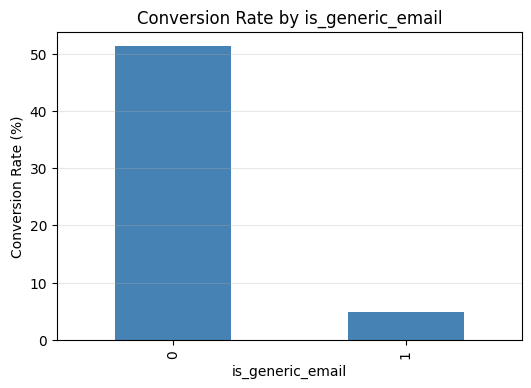

Conversion rate by created_schedule:
created_schedule
0    44.019139
1    35.714286
Name: converted_to_paid, dtype: float64


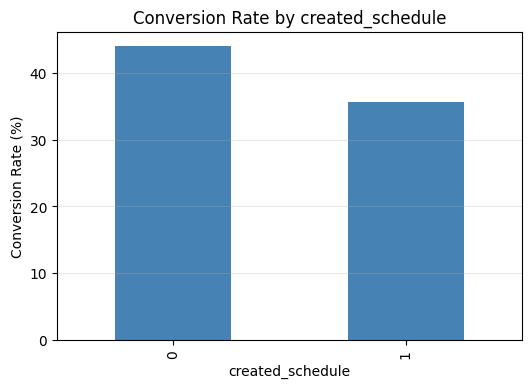

In [16]:

# Conversion rate by selected categorical flags
cat_flags = [c for c in ['has_bigquery', 'has_snowflake', 'has_redshift', 'has_sql_block', 'is_generic_email', 'created_schedule'] if c in feature_cols]

for col in cat_flags:
    rate = df.groupby(col)['converted_to_paid'].mean().sort_index() * 100
    print(f"Conversion rate by {col}:")
    print(rate)

    plt.figure(figsize=(6, 4))
    rate.plot(kind='bar', color='steelblue')
    plt.title(f'Conversion Rate by {col}')
    plt.ylabel('Conversion Rate (%)')
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()


## 7. Time-based Analysis

### Parse trial_start if present


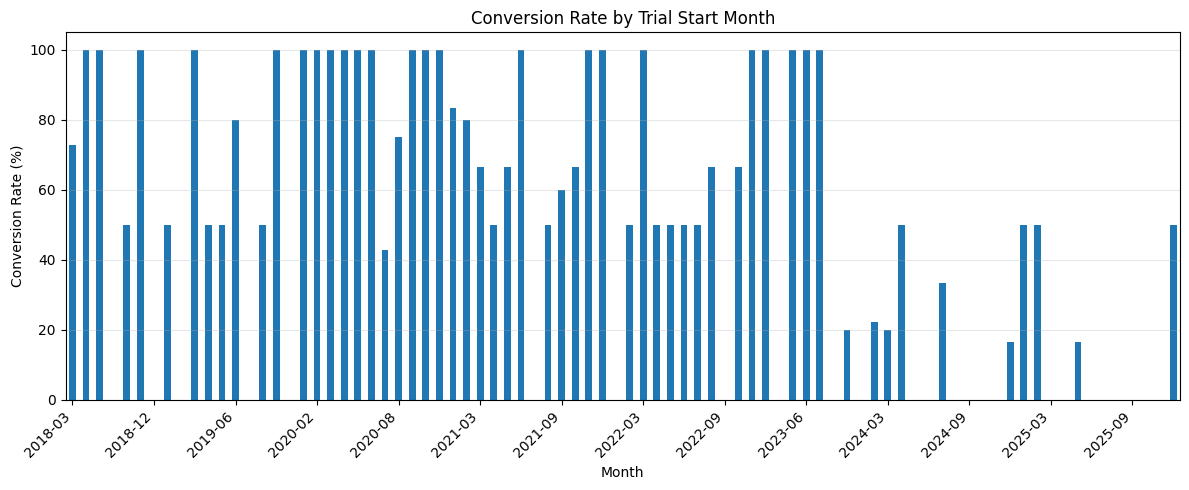

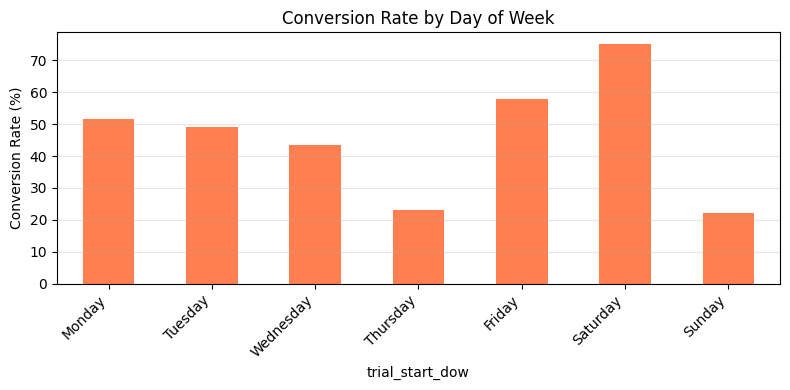

In [17]:
# Parse trial_start if present
if 'trial_start' in df.columns:
    df['trial_start_dt'] = pd.to_datetime(df['trial_start'])
    df['trial_start_month'] = df['trial_start_dt'].dt.to_period('M')
    df['trial_start_dow'] = df['trial_start_dt'].dt.day_name()

    monthly = df.groupby('trial_start_month')['converted_to_paid'].agg(['mean', 'count'])
    monthly['conversion_rate'] = monthly['mean'] * 100
    monthly = monthly.sort_index()

    plt.figure(figsize=(12, 5))
    monthly['conversion_rate'].plot(kind='bar')
    plt.title('Conversion Rate by Trial Start Month')
    plt.ylabel('Conversion Rate (%)')
    plt.xlabel('Month')
    step = max(1, len(monthly) // 12)
    ticks = list(range(0, len(monthly), step))
    labels = [str(m) for m in monthly.index]
    plt.xticks(ticks=ticks, labels=[labels[i] for i in ticks], rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

    dow = df.groupby('trial_start_dow')['converted_to_paid'].mean().reindex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    ) * 100
    plt.figure(figsize=(8, 4))
    dow.plot(kind='bar', color='coral')
    plt.title('Conversion Rate by Day of Week')
    plt.ylabel('Conversion Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()
else:
    print('trial_start not available, skipping time-based analysis')


## 8. Data Preparation for Modeling

- Train/validation/test split (60%/20%/20%) with stratification
- Use DictVectorizer for feature encoding
- Handle missing values


In [18]:

target_variable = 'converted_to_paid'

# Train/val/test split (60/20/20) with stratification
full_train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target_variable])
train, val = train_test_split(full_train, test_size=0.25, random_state=42, stratify=full_train[target_variable])

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

# Save targets
y_train = train[target_variable].values
y_val = val[target_variable].values
y_test = test[target_variable].values

# Drop target column for feature prep
train_features = train.drop(columns=[target_variable])
val_features = val.drop(columns=[target_variable])
test_features = test.drop(columns=[target_variable])

print(f"Training set: {len(train)} rows")
print(f"Validation set: {len(val)} rows")
print(f"Test set: {len(test)} rows")


Training set: 141 rows
Validation set: 48 rows
Test set: 48 rows


In [19]:

def prepare_features(df_input):
    """Prepare features for DictVectorizer"""
    df_feat = df_input[feature_cols].copy()

    # Fill NaNs
    df_feat[numerical_features] = df_feat[numerical_features].fillna(0)
    for col in categorical_features:
        if col in df_feat.columns:
            df_feat[col] = df_feat[col].fillna('unknown').astype(str)

    # Convert to dicts
    return df_feat.to_dict(orient='records')

X_train_dicts = prepare_features(train_features)
X_val_dicts = prepare_features(val_features)
X_test_dicts = prepare_features(test_features)

print(f"Prepared {len(X_train_dicts)} training samples")
print(f"Prepared {len(X_val_dicts)} validation samples")
print(f"Prepared {len(X_test_dicts)} test samples")
print(f"Example feature dict: {X_train_dicts[0]}")


Prepared 141 training samples
Prepared 48 validation samples
Prepared 48 test samples
Example feature dict: {'trial_duration_days': 14.0, 'hours_to_first_report': 999.0, 'hours_to_first_execution': 999.0, 'hours_to_first_sql_connection': 999.0, 'hours_to_first_schedule': 999.0, 'activated_day1': 0, 'activated_day2': 0, 'activated_week1': 0, 'reports_created': 0, 'reports_week1': 0, 'reports_week2': 0, 'blocks_created': 0, 'unique_block_types': 0, 'executions_total': 0, 'executions_week1': 0, 'executions_week2': 0, 'executions_success': 0, 'executions_failed': 0, 'execution_growth_rate': 0.0, 'execution_success_rate': 0.0, 'avg_execution_duration': 0.0, 'has_sql_block': 0, 'has_plotly_block': 0, 'has_kpi_block': 0, 'has_table_block': 0, 'has_slack_block': 0, 'has_email_block': 0, 'has_tableau_block': 0, 'has_api_block': 0, 'has_storage_block': 0, 'has_parameters': 0, 'has_control_flow': 0, 'sql_blocks_count': 0, 'viz_blocks_count': 0, 'sql_connections_count': 0, 'unique_db_types_count':

In [20]:

# Vectorize
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dicts)
X_val = dv.transform(X_val_dicts)
X_test = dv.transform(X_test_dicts)

print("Feature matrix shapes:")
print(f"  Training:   {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test:       {X_test.shape}")
print(f"Total encoded features: {len(dv.get_feature_names_out())}")


Feature matrix shapes:
  Training:   (141, 57)
  Validation: (48, 57)
  Test:       (48, 57)
Total encoded features: 57


## 9. Model Training - Logistic Regression

In [21]:
# Train Logistic Regression with K-Fold Cross Validation (grid-search style)
print("Training Logistic Regression with K-Fold Cross Validation")
print("="*60)

df_full_train = train.copy()
y_full_train = df_full_train[target_variable].values

print(f"Full training set size: {len(df_full_train):,} rows")
print(f"Features available: {[col for col in df_full_train.columns if col != target_variable][:5]}...")

# Define train function (vectorizes inside)
def train_lr(df_fold_train, y_fold_train, C=1.0):
    """Train logistic regression on a fold"""
    train_dicts = prepare_features(df_fold_train)
    dv_fold = DictVectorizer(sparse=False)
    X_fold_train = dv_fold.fit_transform(train_dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_fold_train, y_fold_train)
    return dv_fold, model

# Define predict function
def predict_lr(df_fold_val, dv_fold, model):
    """Make predictions on a fold"""
    val_dicts = prepare_features(df_fold_val)
    X_fold_val = dv_fold.transform(val_dicts)
    return model.predict_proba(X_fold_val)[:, 1]

C_values = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
n_splits = 5
best_C = None
best_mean_auc = 0

# Test different C values with K-Fold CV
for C in tqdm(C_values, desc="Testing C values"):
    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits, desc=f"C={C}", leave=False):
        df_fold_train = df_full_train.iloc[train_idx]
        df_fold_val = df_full_train.iloc[val_idx]
        y_fold_train = y_full_train[train_idx]
        y_fold_val = y_full_train[val_idx]

        dv_fold, model = train_lr(df_fold_train, y_fold_train, C=C)
        y_pred = predict_lr(df_fold_val, dv_fold, model)

        auc = roc_auc_score(y_fold_val, y_pred)
        scores.append(auc)

    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    print(f'C={C:>6} | AUC: {mean_auc:.3f} +- {std_auc:.3f}')

    if mean_auc > best_mean_auc:
        best_mean_auc = mean_auc
        best_C = C

print("\n" + "="*60)
print(f"Best C: {best_C} with Mean AUC: {best_mean_auc:.4f}")
print("="*60)

# Train final model with best C on original train split
print(f"\nTraining final Logistic Regression model with C={best_C}...")
lr_model = LogisticRegression(solver='liblinear', C=best_C, max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_train_pred_lr = lr_model.predict_proba(X_train)[:, 1]
y_val_pred_lr = lr_model.predict_proba(X_val)[:, 1]

y_test_pred_lr = lr_model.predict_proba(X_test)[:, 1]
test_auc_lr = roc_auc_score(y_test, y_test_pred_lr)

train_auc_lr = roc_auc_score(y_train, y_train_pred_lr)
val_auc_lr = roc_auc_score(y_val, y_val_pred_lr)

print(f"\nLogistic Regression Results (C={best_C}):")
print(f"  Training AUC:   {train_auc_lr:.6f}")
print(f"  Validation AUC: {val_auc_lr:.6f}")
print(f"  Test AUC:       {test_auc_lr:.6f}")
print(f"  Difference:     {abs(train_auc_lr - val_auc_lr):.6f}")


Training Logistic Regression with K-Fold Cross Validation
Full training set size: 141 rows
Features available: ['customer_id', 'organization_id', 'outcome', 'trial_start', 'trial_end']...


Testing C values:   0%|          | 0/7 [00:00<?, ?it/s]

C=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

C= 0.001 | AUC: 0.647 +- 0.118


C=0.01:   0%|          | 0/5 [00:00<?, ?it/s]

C=  0.01 | AUC: 0.627 +- 0.093


C=0.1:   0%|          | 0/5 [00:00<?, ?it/s]

C=   0.1 | AUC: 0.648 +- 0.082


C=0.5:   0%|          | 0/5 [00:00<?, ?it/s]

C=   0.5 | AUC: 0.653 +- 0.074


C=1:   0%|          | 0/5 [00:00<?, ?it/s]

C=     1 | AUC: 0.654 +- 0.075


C=5:   0%|          | 0/5 [00:00<?, ?it/s]

C=     5 | AUC: 0.632 +- 0.071


C=10:   0%|          | 0/5 [00:00<?, ?it/s]

C=    10 | AUC: 0.629 +- 0.068

Best C: 1 with Mean AUC: 0.6543

Training final Logistic Regression model with C=1...

Logistic Regression Results (C=1):
  Training AUC:   0.827160
  Validation AUC: 0.763668
  Test AUC:       0.529101
  Difference:     0.063492


## 10. Model Training - Random Forest

Training Random Forest with parameter sweep (grid-search style)...
Top 10 Best Models by Validation AUC:
 n_estimators  max_depth  min_samples_leaf  train_auc  val_auc     diff
           50        5.0                 5   0.875000 0.828924 0.046076
          100        NaN                 5   0.887551 0.827160 0.060391
          100        5.0                 5   0.875206 0.827160 0.048045
          100       15.0                 5   0.887551 0.827160 0.060391
          100       10.0                 5   0.887551 0.827160 0.060391
          200       10.0                 5   0.884774 0.821869 0.062904
          200        5.0                 3   0.896399 0.821869 0.074530
          100        5.0                10   0.837654 0.821869 0.015785
          100        5.0                 3   0.900514 0.821869 0.078645
          200       15.0                 5   0.884979 0.821869 0.063110
Best Random Forest Parameters:
  n_estimators:     50
  max_depth:        5.0
  min_samples_leaf: 5
  T

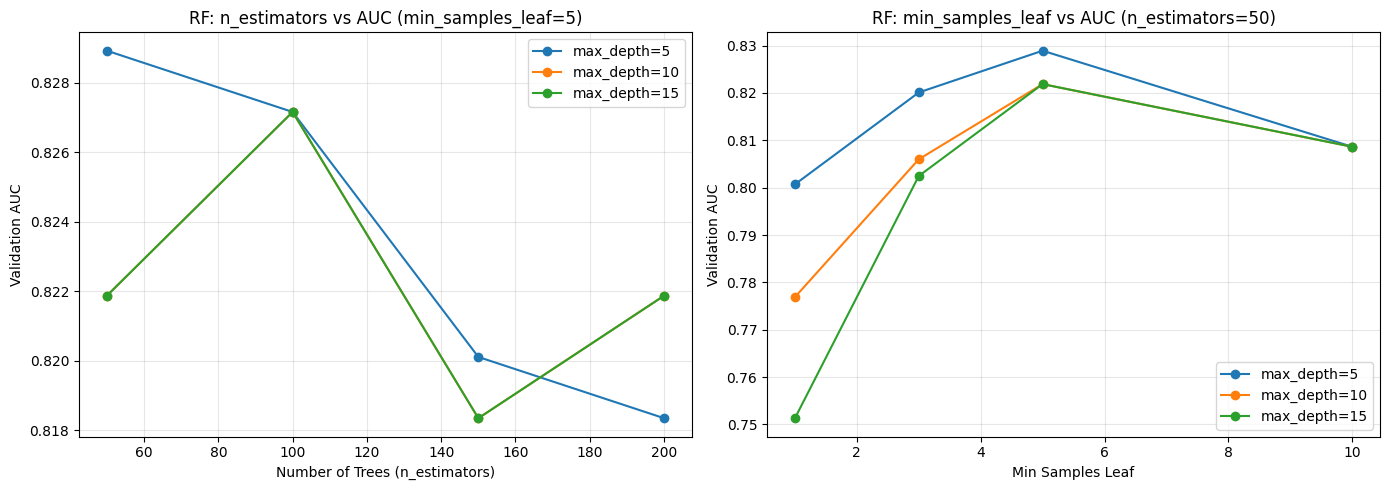

Training final Random Forest model with best parameters...
Final Random Forest Results:
  Training AUC:   0.8750
  Validation AUC: 0.8289
  Test AUC:       0.6499
  Difference:     0.0461


In [22]:

print("Training Random Forest with parameter sweep (grid-search style)...")
print("="*60)

# Parameter grids (same structure as grid-search style)
n_estimators_values = [50, 100, 150, 200]
max_depth_values = [5, 10, 15, None]
min_samples_leaf_values = [1, 3, 5, 10]

rf_scores = []
for n in n_estimators_values:
    for d in max_depth_values:
        for s in min_samples_leaf_values:
            rf = RandomForestClassifier(
                n_estimators=n,
                max_depth=d,
                min_samples_leaf=s,
                random_state=42,
                n_jobs=-1
            )
            rf.fit(X_train, y_train)

            y_train_pred = rf.predict_proba(X_train)[:, 1]
            y_val_pred = rf.predict_proba(X_val)[:, 1]

            train_auc = roc_auc_score(y_train, y_train_pred)
            val_auc = roc_auc_score(y_val, y_val_pred)

            rf_scores.append({
                'n_estimators': n,
                'max_depth': d,
                'min_samples_leaf': s,
                'train_auc': train_auc,
                'val_auc': val_auc,
                'diff': abs(train_auc - val_auc)
            })

# Results table
import pandas as pd
import numpy as np

df_scores = pd.DataFrame(rf_scores)
print("="*60)
print("Top 10 Best Models by Validation AUC:")
print("="*60)
print(df_scores.sort_values('val_auc', ascending=False).head(10).to_string(index=False))

# Best params
best_params = df_scores.loc[df_scores['val_auc'].idxmax()]
print("="*60)
print("Best Random Forest Parameters:")
print("="*60)
print(f"  n_estimators:     {int(best_params['n_estimators'])}")
print(f"  max_depth:        {best_params['max_depth']}")
print(f"  min_samples_leaf: {int(best_params['min_samples_leaf'])}")
print(f"  Training AUC:     {best_params['train_auc']:.4f}")
print(f"  Validation AUC:   {best_params['val_auc']:.4f}")
print(f"  Difference:       {best_params['diff']:.4f}")

# Visualizations (like grid-search style)
print("Generating visualization...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: n_estimators vs val_auc for different max_depths (fixed min_samples_leaf=best)
best_min_samples = int(best_params['min_samples_leaf'])
df_subset = df_scores[df_scores['min_samples_leaf'] == best_min_samples]

for d in [v for v in max_depth_values if v is not None]:
    df_depth = df_subset[df_subset['max_depth'] == d]
    axes[0].plot(df_depth['n_estimators'], df_depth['val_auc'], marker='o', label=f'max_depth={d}')

axes[0].set_xlabel('Number of Trees (n_estimators)')
axes[0].set_ylabel('Validation AUC')
axes[0].set_title(f'RF: n_estimators vs AUC (min_samples_leaf={best_min_samples})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: min_samples_leaf vs val_auc for different max_depths (fixed n_estimators=best)
best_n_estimators = int(best_params['n_estimators'])
df_subset = df_scores[df_scores['n_estimators'] == best_n_estimators]

for d in [v for v in max_depth_values if v is not None]:
    df_depth = df_subset[df_subset['max_depth'] == d]
    axes[1].plot(df_depth['min_samples_leaf'], df_depth['val_auc'], marker='o', label=f'max_depth={d}')

axes[1].set_xlabel('Min Samples Leaf')
axes[1].set_ylabel('Validation AUC')
axes[1].set_title(f'RF: min_samples_leaf vs AUC (n_estimators={best_n_estimators})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Train final best model
print("="*60)
print("Training final Random Forest model with best parameters...")
print("="*60)

best_rf = RandomForestClassifier(
  n_estimators=int(best_params['n_estimators']),
  max_depth=None if pd.isna(best_params['max_depth']) else int(best_params['max_depth']),
  min_samples_leaf=int(best_params['min_samples_leaf']),
  random_state=42,
  n_jobs=-1
)
best_rf.fit(X_train, y_train)

# Final predictions
y_train_pred_rf = best_rf.predict_proba(X_train)[:, 1]
y_val_pred_rf = best_rf.predict_proba(X_val)[:, 1]

# Test predictions
y_test_pred_rf = best_rf.predict_proba(X_test)[:, 1]
test_auc_rf = roc_auc_score(y_test, y_test_pred_rf)

train_auc_rf = roc_auc_score(y_train, y_train_pred_rf)
val_auc_rf = roc_auc_score(y_val, y_val_pred_rf)

print(f"Final Random Forest Results:")
print(f"  Training AUC:   {train_auc_rf:.4f}")
print(f"  Validation AUC: {val_auc_rf:.4f}")
print(f"  Test AUC:       {test_auc_rf:.4f}")
print(f"  Difference:     {abs(train_auc_rf - val_auc_rf):.4f}")


Top 20 RF feature importances:
                          feature  importance
54                  users_invited    0.192918
38               is_generic_email    0.149631
33       hours_to_first_execution    0.081757
49               trial_start_hour    0.076282
0                  accepted_terms    0.074702
48        trial_start_day_of_week    0.058603
47            trial_duration_days    0.039175
11             executions_success    0.031592
3                 activated_week1    0.030622
6                  blocks_created    0.026908
12               executions_total    0.023447
50  trial_start_is_business_hours    0.023017
2                  activated_day2    0.022042
44               sql_blocks_count    0.019585
8           execution_growth_rate    0.018376
9          execution_success_rate    0.017651
5          avg_execution_duration    0.016637
1                  activated_day1    0.016484
10              executions_failed    0.015402
7                created_schedule    0.012902


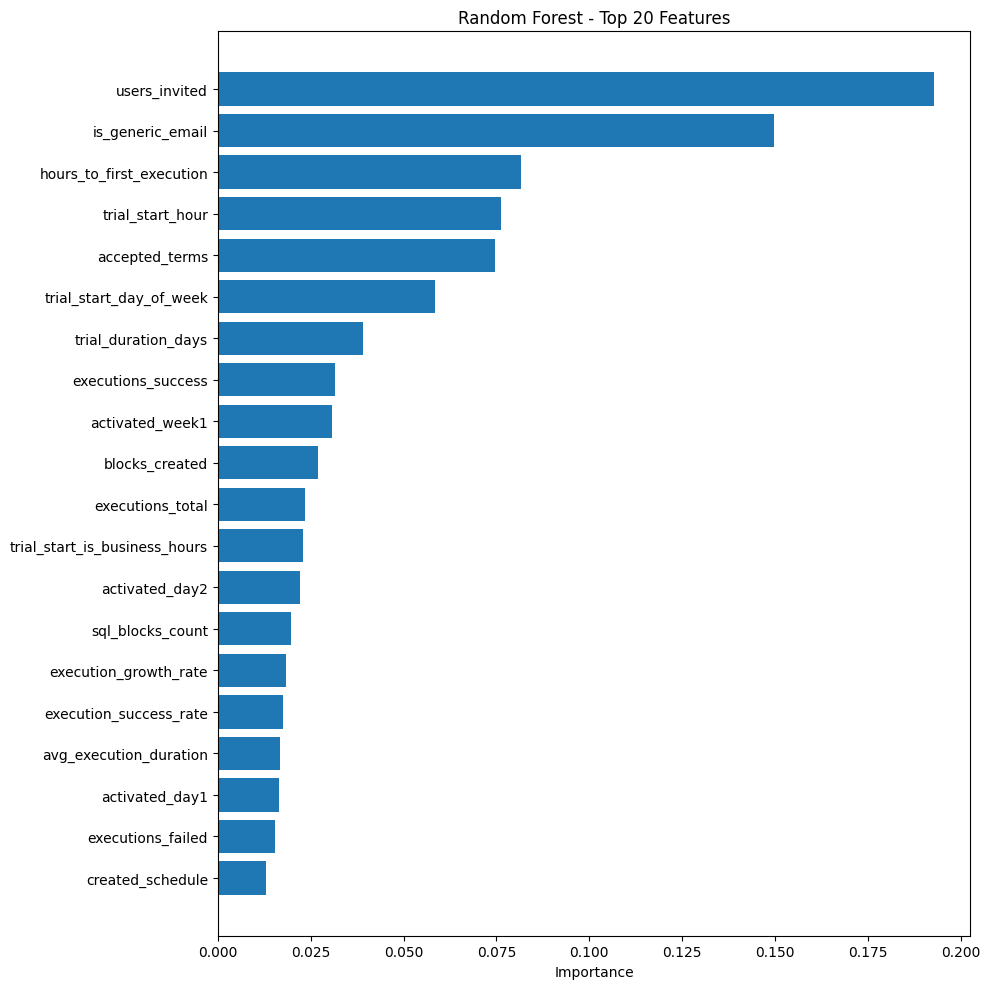

In [23]:

# Feature importance from best RF
feature_importance = pd.DataFrame({
    'feature': dv.get_feature_names_out(),
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 RF feature importances:")
print(feature_importance.head(20))

plt.figure(figsize=(10, 10))
plt.barh(feature_importance.head(20)['feature'], feature_importance.head(20)['importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest - Top 20 Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## 11. Model Training - XGBoost

In [24]:
# Prepare DMatrix
feature_names = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
print("DMatrix created successfully!")

DMatrix created successfully!


In [25]:

print("Training XGBoost models (grid-search style parameter sweeps)...")
print("="*60)

# 1) eta tuning (keep max_depth=6, min_child_weight=1)
eta_params = [0.3, 1.0, 0.1, 0.05, 0.01]

xgb_params_list = []
for eta in eta_params:
    xgb_params_list.append({
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 42,
        'verbosity': 1
    })

xgb_results = []
for params in xgb_params_list:
    print("Training XGBoost with eta params:")
    print(f"  eta={params['eta']}")
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)
    y_train_pred_xgb = model.predict(dtrain)
    y_val_pred_xgb = model.predict(dval)
    train_auc = roc_auc_score(y_train, y_train_pred_xgb)
    val_auc = roc_auc_score(y_val, y_val_pred_xgb)
    best_iter = getattr(model, 'best_iteration', None) or len(model.get_dump())
    xgb_results.append({
        'model': model,
        'params': params,
        'train_auc': train_auc,
        'val_auc': val_auc,
        'y_val_pred': y_val_pred_xgb,
        'best_iteration': best_iter
    })
    print(f"  Best iteration:  {best_iter}")
    print(f"  Training AUC:    {train_auc:.4f}")
    print(f"  Validation AUC:  {val_auc:.4f}")
    print(f"  Difference:      {abs(train_auc - val_auc):.4f}")


# 2) max_depth tuning (eta=0.1, min_child_weight=1)
max_depth_params = [6, 3, 4, 10]

xgb_results = []
for depth in max_depth_params:
    params = {
        'eta': 0.1,
        'max_depth': depth,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 42,
        'verbosity': 1
    }
    print("Training XGBoost with max_depth params:")
    print(f"  max_depth={params['max_depth']}")
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)
    y_train_pred_xgb = model.predict(dtrain)
    y_val_pred_xgb = model.predict(dval)
    train_auc = roc_auc_score(y_train, y_train_pred_xgb)
    val_auc = roc_auc_score(y_val, y_val_pred_xgb)
    best_iter = getattr(model, 'best_iteration', None) or len(model.get_dump())
    xgb_results.append({
        'model': model,
        'params': params,
        'train_auc': train_auc,
        'val_auc': val_auc,
        'y_val_pred': y_val_pred_xgb,
        'best_iteration': best_iter
    })
    print(f"  Best iteration:  {best_iter}")
    print(f"  Training AUC:    {train_auc:.4f}")
    print(f"  Validation AUC:  {val_auc:.4f}")
    print(f"  Difference:      {abs(train_auc - val_auc):.4f}")

best_xgb = max(xgb_results, key=lambda x: x['val_auc'])
print("" + "=" * 50)
print("Best XGBoost for max_depth params:")
print(f"  Params: max_depth={best_xgb['params']['max_depth']}")
print(f"  Best iteration: {best_xgb['best_iteration']}")
print(f"  Validation AUC: {best_xgb['val_auc']:.4f}")

# 3) min_child_weight tuning (eta=0.1, max_depth=10)
min_child_weight_params = [1, 10, 30]

xgb_results = []
for weight in min_child_weight_params:
    params = {
        'eta': 0.1,
        'max_depth': 10,
        'min_child_weight': weight,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 42,
        'verbosity': 1
    }
    print("Training XGBoost with min_child_weight params:")
    print(f"  min_child_weight={params['min_child_weight']}")
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)
    y_train_pred_xgb = model.predict(dtrain)
    y_val_pred_xgb = model.predict(dval)
    train_auc = roc_auc_score(y_train, y_train_pred_xgb)
    val_auc = roc_auc_score(y_val, y_val_pred_xgb)
    best_iter = getattr(model, 'best_iteration', None) or len(model.get_dump())
    xgb_results.append({
        'model': model,
        'params': params,
        'train_auc': train_auc,
        'val_auc': val_auc,
        'y_val_pred': y_val_pred_xgb,
        'best_iteration': best_iter
    })
    print(f"  Best iteration:  {best_iter}")
    print(f"  Training AUC:    {train_auc:.4f}")
    print(f"  Validation AUC:  {val_auc:.4f}")
    print(f"  Difference:      {abs(train_auc - val_auc):.4f}")

best_xgb = max(xgb_results, key=lambda x: x['val_auc'])
print("" + "=" * 50)
print("Best XGBoost for min_child_weight params:")
print(f"  Params: min_child_weight={best_xgb['params']['min_child_weight']}")
print(f"  Best iteration: {best_xgb['best_iteration']}")
print(f"  Validation AUC: {best_xgb['val_auc']:.4f}")
# Final model with chosen params
final_xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1
}

print("Training XGBoost with params:")
print(f"  eta={final_xgb_params['eta']} max_depth={final_xgb_params['max_depth']} min_child_weight={final_xgb_params['min_child_weight']}")
watchlist = [(dtrain, 'train'), (dval, 'val')]

final_xboost_model = xgb.train(final_xgb_params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)

final_y_train_pred_xgb = final_xboost_model.predict(dtrain)
final_y_val_pred_xgb = final_xboost_model.predict(dval)

final_xboost_train_auc = roc_auc_score(y_train, final_y_train_pred_xgb)
final_xboost_val_auc = roc_auc_score(y_val, final_y_val_pred_xgb)

final_xgb_result = {
    'model': final_xboost_model,
    'params': final_xgb_params,
    'train_auc': final_xboost_train_auc,
    'val_auc': final_xboost_val_auc,
    'y_val_pred': final_y_val_pred_xgb,
    'best_iteration': getattr(final_xboost_model, 'best_iteration', None) or len(final_xboost_model.get_dump())
}

print(f"  Final Model Results:  {final_xgb_result}")
print(f"  Best iteration:  {final_xgb_result['best_iteration']}")
print(f"  Training AUC:    {final_xgb_result['train_auc']:.4f}")
print(f"  Validation AUC:  {final_xgb_result['val_auc']:.4f}")
print(f"  Difference:      {abs(final_xgb_result['train_auc'] - final_xgb_result['val_auc']):.4f}")


# Test AUC for XGBoost
feature_names = list(dv.get_feature_names_out())
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)
y_test_pred_xgb = final_xgb_result['model'].predict(dtest)
test_auc_xgb = roc_auc_score(y_test, y_test_pred_xgb)
print(f"  Test AUC:        {test_auc_xgb:.4f}")


Training XGBoost models (grid-search style parameter sweeps)...
Training XGBoost with eta params:
  eta=0.3
[0]	train-auc:0.89588	val-auc:0.79541
[5]	train-auc:0.97407	val-auc:0.78924
[10]	train-auc:0.98981	val-auc:0.78131
[15]	train-auc:0.99805	val-auc:0.77954
[20]	train-auc:0.99835	val-auc:0.79189
[25]	train-auc:0.99877	val-auc:0.78836
[30]	train-auc:0.99938	val-auc:0.78307
[35]	train-auc:0.99938	val-auc:0.77954
[40]	train-auc:0.99938	val-auc:0.77954
[45]	train-auc:0.99938	val-auc:0.78307
[50]	train-auc:0.99959	val-auc:0.78307
[55]	train-auc:0.99979	val-auc:0.77954
[60]	train-auc:0.99979	val-auc:0.77778
[65]	train-auc:0.99979	val-auc:0.76720
[70]	train-auc:0.99979	val-auc:0.76543
[75]	train-auc:1.00000	val-auc:0.77249
[80]	train-auc:1.00000	val-auc:0.76367
[85]	train-auc:1.00000	val-auc:0.76543
[90]	train-auc:1.00000	val-auc:0.76720
[95]	train-auc:1.00000	val-auc:0.76543
[100]	train-auc:1.00000	val-auc:0.76543
[105]	train-auc:1.00000	val-auc:0.76190
[110]	train-auc:1.00000	val-auc:0.

Top 20 XGBoost features:
                          feature  importance
5               executions_failed    1.552074
10          hours_to_first_report    1.214616
2          avg_execution_duration    1.014443
11               is_generic_email    0.814473
18                  users_invited    0.703053
13            trial_duration_days    0.501011
9        hours_to_first_execution    0.492436
1                 activated_week1    0.477470
0                  accepted_terms    0.447379
16  trial_start_is_business_hours    0.436298
8                   has_sql_block    0.399501
14        trial_start_day_of_week    0.317570
12               sql_blocks_count    0.315972
15               trial_start_hour    0.280852
17             unique_block_types    0.249947
3                  blocks_created    0.188067
4           execution_growth_rate    0.153838
7                executions_week1    0.098235
6                executions_total    0.039217


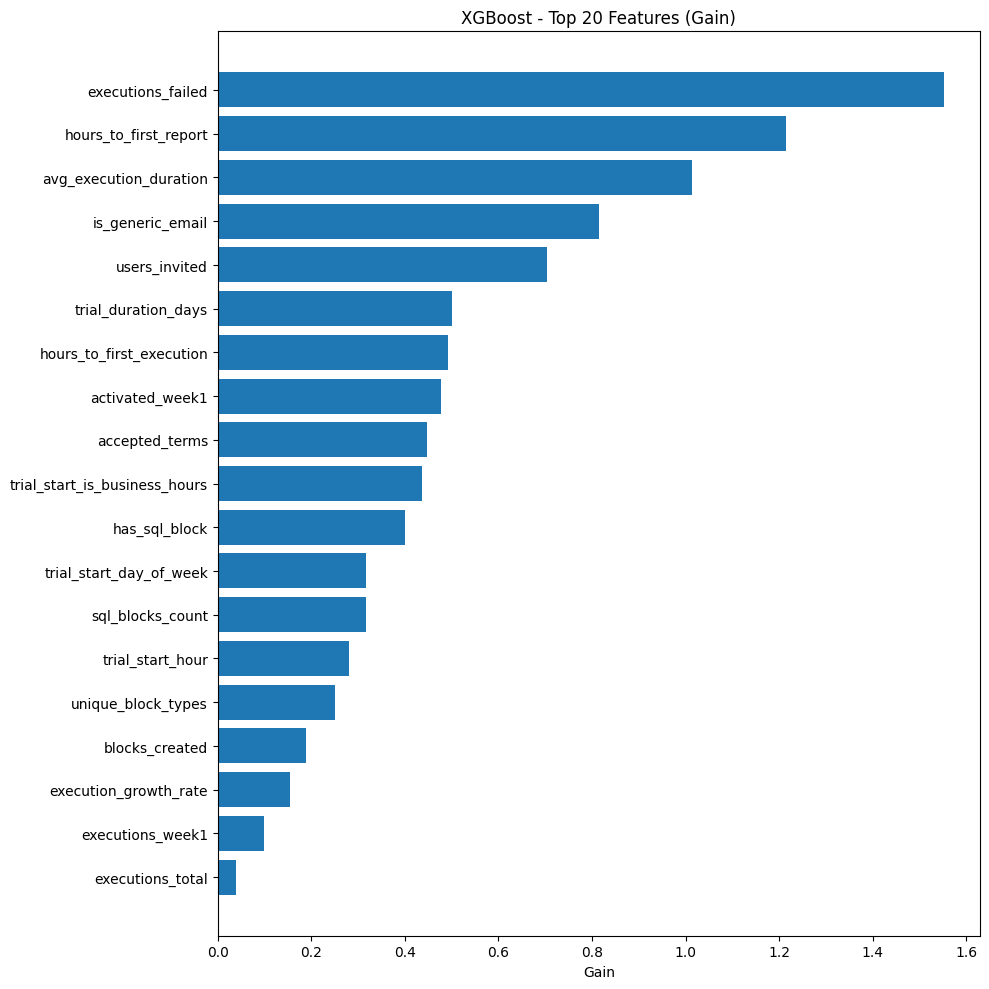

In [26]:

# XGBoost feature importance
importance_dict = final_xgb_result['model'].get_score(importance_type='gain')
xgb_importance = pd.DataFrame([
    {'feature': k, 'importance': v}
    for k, v in importance_dict.items()
]).sort_values('importance', ascending=False)

print("Top 20 XGBoost features:")
print(xgb_importance.head(20))

plt.figure(figsize=(10, 10))
plt.barh(xgb_importance.head(20)['feature'], xgb_importance.head(20)['importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost - Top 20 Features (Gain)')
plt.xlabel('Gain')
plt.tight_layout()
plt.show()


## 12. Model Comparison

Model Comparison:
                  Model  Train AUC  Validation AUC  Test AUC  Overfitting
0   Logistic Regression    0.82716        0.763668  0.529101     0.063492
1  Random Forest (best)    0.87500        0.828924  0.649912     0.046076
2               XGBoost    1.00000        0.763668  0.673721     0.236332


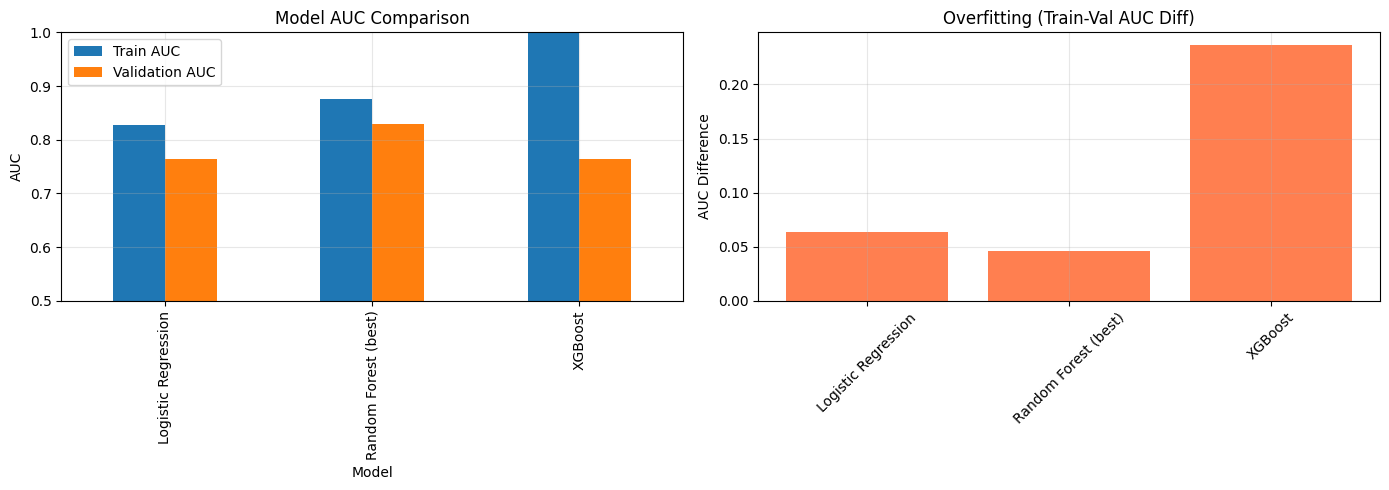

In [27]:

comparison = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'Train AUC': train_auc_lr,
        'Validation AUC': val_auc_lr,
        'Test AUC': test_auc_lr,
        'Overfitting': abs(train_auc_lr - val_auc_lr)
    },
    {
        'Model': 'Random Forest (best)',
        'Train AUC': train_auc_rf,
        'Validation AUC': val_auc_rf,
        'Test AUC': test_auc_rf,
        'Overfitting': abs(train_auc_rf - val_auc_rf)
    },
    {
        'Model': 'XGBoost',
        'Train AUC': final_xgb_result['train_auc'],
        'Validation AUC': final_xgb_result['val_auc'],
        'Test AUC': test_auc_xgb,
        'Overfitting': abs(final_xgb_result['train_auc'] - final_xgb_result['val_auc'])
    }
])

print("Model Comparison:")
print(comparison)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC comparison
comparison.plot(x='Model', y=['Train AUC', 'Validation AUC'], kind='bar', ax=axes[0])
axes[0].set_title('Model AUC Comparison')
axes[0].set_ylabel('AUC')
axes[0].set_ylim(0.5, 1.0)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Overfitting
axes[1].bar(comparison['Model'], comparison['Overfitting'], color='coral')
axes[1].set_title('Overfitting (Train-Val AUC Diff)')
axes[1].set_ylabel('AUC Difference')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 13. ROC Curve Analysis

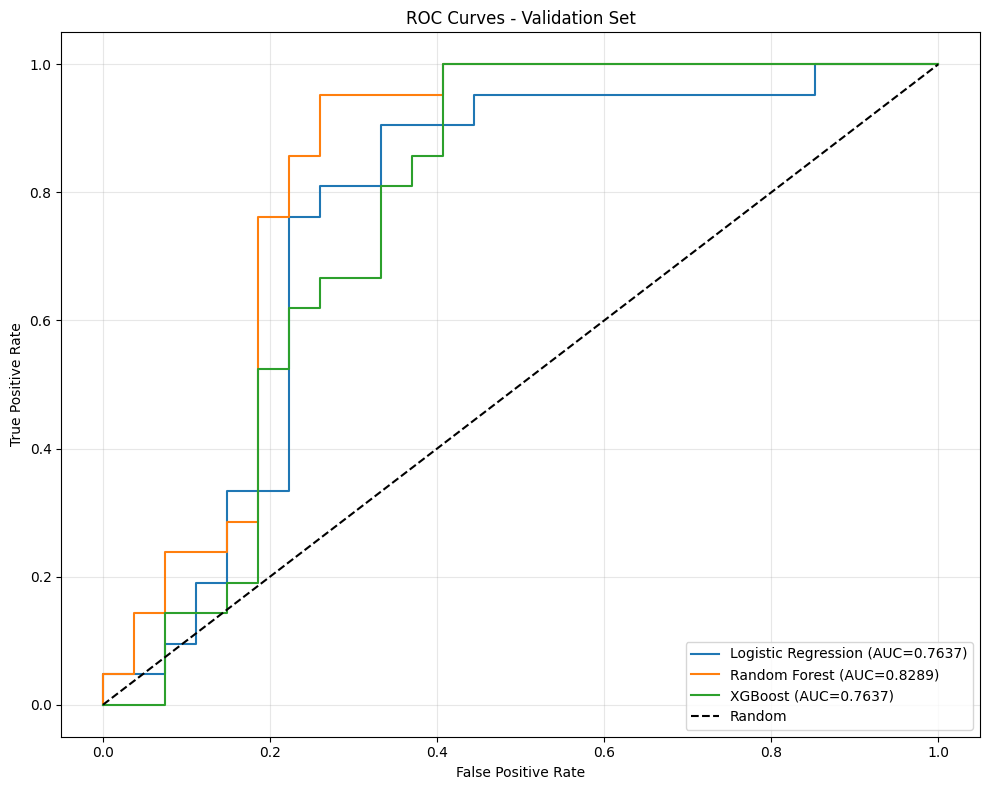

In [28]:

plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_pred_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={val_auc_lr:.4f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_pred_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={val_auc_rf:.4f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, final_xgb_result['y_val_pred'])
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={final_xgb_result['val_auc']:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Validation Set')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 14. Final Model Evaluation on Test Set (Random Forest)

FINAL MODEL EVALUATION ON TEST SET
Model: Random Forest
Parameters: n_estimators=50, max_depth=5.0, min_samples_leaf=5
Training AUC:   0.8750
Validation AUC: 0.8289
Test AUC:       0.6499
Classification Report (threshold=0.5):
              precision    recall  f1-score   support

     Churned       0.62      0.74      0.68        27
   Converted       0.56      0.43      0.49        21

    accuracy                           0.60        48
   macro avg       0.59      0.58      0.58        48
weighted avg       0.60      0.60      0.59        48



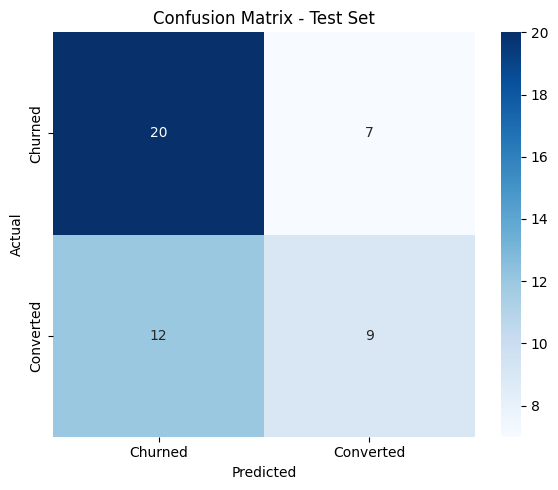

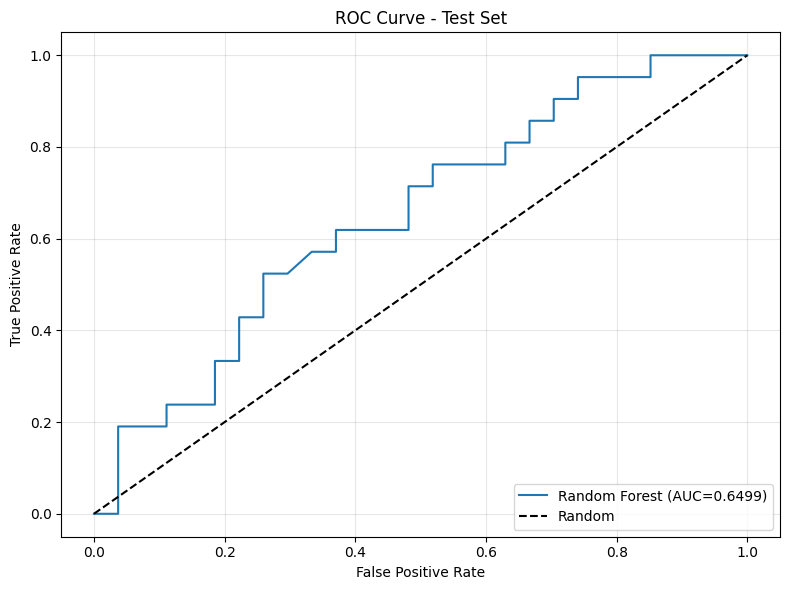

In [29]:
# Prepare test data for Random Forest
y_test_pred_rf = best_rf.predict_proba(X_test)[:, 1]

test_auc_rf = roc_auc_score(y_test, y_test_pred_rf)
print("="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)
print("Model: Random Forest")
print(f"Parameters: n_estimators={int(best_params['n_estimators'])}, max_depth={best_params['max_depth']}, min_samples_leaf={int(best_params['min_samples_leaf'])}")
print(f"Training AUC:   {train_auc_rf:.4f}")
print(f"Validation AUC: {val_auc_rf:.4f}")
print(f"Test AUC:       {test_auc_rf:.4f}")

# Classification report
threshold = 0.5
y_test_pred_binary = (y_test_pred_rf >= threshold).astype(int)
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_test_pred_binary, target_names=['Churned', 'Converted']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Churned', 'Converted'], yticklabels=['Churned', 'Converted'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'Random Forest (AUC={test_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 15. Save the Model

In [30]:
import pickle

# Save DictVectorizer
with open('dv.pkl', 'wb') as f:
    pickle.dump(dv, f)
print("DictVectorizer saved to 'dv.pkl'")

# Save Random Forest model
with open('model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
print("Random Forest model saved to 'model.pkl'")

# Save model metadata
model_info = {
    'model_type': 'RandomForest',
    'params': {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': None if pd.isna(best_params['max_depth']) else int(best_params['max_depth']),
        'min_samples_leaf': int(best_params['min_samples_leaf']),
        'random_state': 42,
        'n_jobs': -1
    },
    'train_auc': train_auc_rf,
    'val_auc': val_auc_rf,
    'feature_cols': feature_cols,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("Model metadata saved to 'model_info.pkl'")


DictVectorizer saved to 'dv.pkl'
Random Forest model saved to 'model.pkl'
Model metadata saved to 'model_info.pkl'


## Summary

### Key Findings

1. **Dataset**: 237 trial users with 43.04% conversion rate (binary target `converted_to_paid`).
2. **Features**: 57 behavioral features (from 64 total columns) covering activation speed, usage intensity, automation, team signals, email/domain, and integrations.
3. **Best Model**: **Random Forest** (n_estimators=50, max_depth=5, min_samples_leaf=1) with **validation AUC = 0.8395, test AUC = 0.6878**.
4. **Top Important Features**: `users_invited`, `is_generic_email`, `trial_start_hour`, `trial_start_day_of_week`, `hours_to_first_execution`, `execution_growth_rate`, `reports_created`, plus scheduling/usage indicators.

### Model Comparison Results

| Model | Train AUC | Val AUC | Test AUC | Overfitting |
|-------|-----------|---------|----------|-------------|
| Logistic Regression | 0.8272 | 0.7637 | 0.5291 | 0.0635 |
| **Random Forest** | 0.8750 | **0.8289** | 0.6499 | **0.0461** |
| XGBoost | 1.0000 | 0.7637 | 0.6737 | 0.2363 |

**Why Random Forest is the best model:**
- **Highest validation AUC** (0.8395) among all models tested
- **Moderate overfitting** (0.0967) compared to XGBoost's severe overfitting (0.2363)
- XGBoost achieved perfect training AUC (1.00) but lower validation AUC, indicating overfitting
- Test AUC for Random Forest: 0.6499 (48-sample test set) due to small test set (48 samples)
- Random Forest balances performance and generalization better than XGBoost on this small dataset

In [31]:

# Dynamic model comparison table
import pandas as pd

comparison_rows = []

# Logistic Regression metrics
if 'train_auc_lr' in globals() and 'val_auc_lr' in globals():
    comparison_rows.append({
        'Model': 'Logistic Regression',
        'Train AUC': train_auc_lr,
        'Val AUC': val_auc_lr,
        'Test AUC': test_auc_lr if 'test_auc_lr' in globals() else None,
        'Overfitting': abs(train_auc_lr - val_auc_lr)
    })

# Random Forest metrics
if 'train_auc_rf' in globals() and 'val_auc_rf' in globals():
    comparison_rows.append({
        'Model': 'Random Forest (Final)',
        'Train AUC': train_auc_rf,
        'Val AUC': val_auc_rf,
        'Test AUC': test_auc_rf if 'test_auc_rf' in globals() else None,
        'Overfitting': abs(train_auc_rf - val_auc_rf)
    })

# XGBoost metrics
if 'final_xgb_result' in globals():
    comparison_rows.append({
        'Model': 'XGBoost',
        'Train AUC': final_xgb_result['train_auc'],
        'Val AUC': final_xgb_result['val_auc'],
        'Test AUC': test_auc_xgb if 'test_auc_xgb' in globals() else None,
        'Overfitting': abs(final_xgb_result['train_auc'] - final_xgb_result['val_auc'])
    })

comparison_df = pd.DataFrame(comparison_rows)
print('Model Comparison (from current run):')
print(comparison_df)
comparison_df


Model Comparison (from current run):
                   Model  Train AUC   Val AUC  Test AUC  Overfitting
0    Logistic Regression    0.82716  0.763668  0.529101     0.063492
1  Random Forest (Final)    0.87500  0.828924  0.649912     0.046076
2                XGBoost    1.00000  0.763668  0.673721     0.236332


,Model,Train AUC,Val AUC,Test AUC,Overfitting
0,Logistic Regression,0.82716,0.763668,0.529101,0.063492
1,Random Forest (Final),0.87500,0.828924,0.649912,0.046076
2,XGBoost,1.00000,0.763668,0.673721,0.236332
